# Practice Session 09: Forecasting

In this session we will take a dataset containing a time series of sales of furniture per day (I could not find something even more boring, sorry), analyze and perform some forecasts on it. The idea of analyzing this time series comes from [this blogpost](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b) where they use Python's `statsmodel` and other libraries to perform a similar analysis.

# 0. Preliminaries

The dataset we will use is derived from the "[Superstore dataset](https://community.tableau.com/docs/DOC-1236)" that has been used for exercises and learning in Tableau.

## 0.1. Required imports

In [1]:
import io
import csv
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

## 0.2. How to read the file

There is a lot we could do here, including using Pandas' methods for reading a CSV file, converting the column *sales* into an index, and so on. We will simply read the file into a matrix ...

In [2]:
sales_matrix = []

INPUT_FILE = "Datasets/furniture-sales.csv"
with io.open(INPUT_FILE) as file:
    reader = csv.DictReader(file, delimiter=",")
    for row in reader:
        sales_matrix.append([datetime.datetime.strptime(row['Date'], '%Y-%m-%d'), float(row['Sales'])])
print("Read %d rows from %s to %s" % (len(sales_matrix), sales_matrix[0][0].strftime("%Y-%m-%d"), sales_matrix[-1][0].strftime("%Y-%m-%d")))

Read 889 rows from 2014-01-06 to 2017-12-30


... then sort data by day, in case it is not already sorted, and create a data frame.

In [3]:
sales_matrix = sorted(sales_matrix)
sales_per_day = pd.DataFrame(sales_matrix, columns=['day', 'sales'])
print(sales_per_day.head())
print("...")
print(sales_per_day.tail())

         day     sales
0 2014-01-06  2573.820
1 2014-01-07    76.728
2 2014-01-10    51.940
3 2014-01-11     9.940
4 2014-01-13   879.939
...
           day      sales
884 2017-12-24  1393.4940
885 2017-12-25   832.4540
886 2017-12-28   551.2568
887 2017-12-29  2330.7180
888 2017-12-30   323.1360


We plot the original series. We notice that there is a substantial variability in sales from day to day.

C:\Users\roger\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


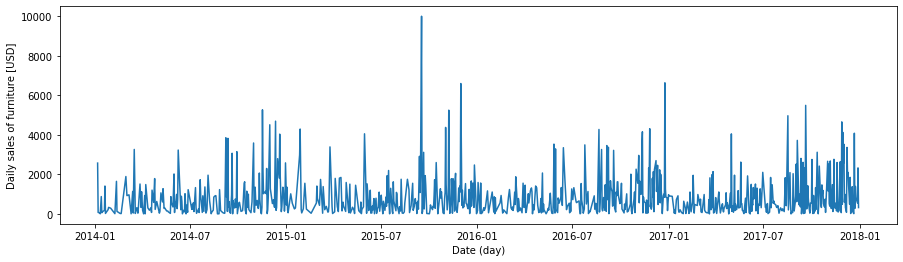

In [4]:
plt.figure(figsize=(15,4))
plt.xlabel('Date (day)')
plt.ylabel('Daily sales of furniture [USD]')
_ = plt.plot_date(sales_per_day['day'], sales_per_day['sales'], fmt='-')

# 1. Smooth this series

The original series has strong variations from one day to the next one, so we will smooth the series before using it. Here we will use three smoothing methods: moving averages, binning by floating time periods, and binning by calendar time periods.

## 1.1 Smooth the series using moving averages

We will compute a moving average of the previous `window_length` days of sales (e.g., 7) as a way of smoothing the time series.

[**CODE**] Complete the code below to compute moving average.

In [5]:
window_length = 7
window = []
smoothed_series_matrix = []

for index, row in sales_per_day.iterrows():
    
    # YOUR_CODE_HERE
    # The variable "window" should contain the last window_length observations of row['sales']
    if len(window) >= window_length:
        window.pop(0)
    window.append(row['sales'])
    
    assert(len(window) <= window_length)
    moving_average = np.mean(window)
    smoothed_series_matrix.append([row['day'], moving_average])
    
smoothed_series = pd.DataFrame(smoothed_series_matrix, columns=['day', 'sales_average'])
print(smoothed_series.head())
print("...")
print(smoothed_series.tail())

         day  sales_average
0 2014-01-06    2573.820000
1 2014-01-07    1325.274000
2 2014-01-10     900.829333
3 2014-01-11     678.107000
4 2014-01-13     718.473400
...
           day  sales_average
884 2017-12-24    1129.043286
885 2017-12-25    1158.071000
886 2017-12-28    1039.581829
887 2017-12-29    1356.058971
888 2017-12-30    1399.946971


Now we plot the resulting series, observing that it is, well, smoother.

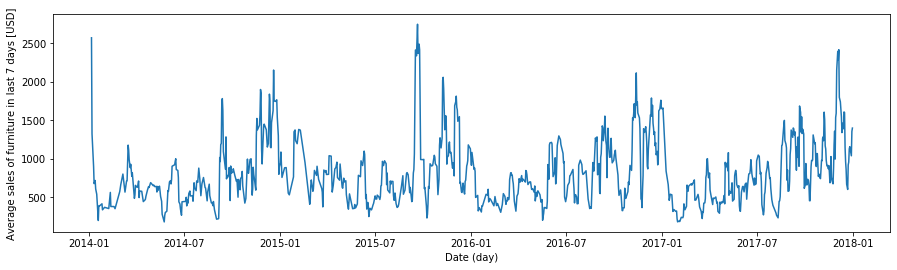

In [6]:
plt.figure(figsize=(15,4))
plt.xlabel('Date (day)')
plt.ylabel('Average sales of furniture in last %d days [USD]' % window_length)
_ = plt.plot_date(smoothed_series['day'], smoothed_series['sales_average'], fmt='-')

[**REPORT**] Include the original and moving average plots in your report, plus a brief commentary.

## 1.2. Smooth the series by binning per floating weeks

Note: Pandas have powerful methods for [re-sampling a series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html) that we will **not** use. Instead, we want to understand every step of the resampling process.

First, we build a list of `weeks` that starts with the first day of the studied period and then adds one week until passing over the last day of the studied period. There should be **209** week starts in your dataset, if you have just 208 you need to add one more in the end, it will make your life easier. Note these weeks *float* because they do not start in the calendar start of the week such as Monday.

[**CODE**] Complete the function `list_of_floating_week_starts`. It should generate a list such that:

* The first element should be *first*
* The next elements should be *first + 1 week*, *first + 2 weeks*, ...
* To add one week to date *D*, use `D + datetime.timedelta(weeks=1)`
* The last element should be in the week after *last*

In [7]:
def list_of_floating_week_starts(first, last):
    weeks = []
    
    # YOUR CODE HERE
    current_time = first
    while current_time <= last:
        weeks.append(current_time)
        current_time += datetime.timedelta(weeks=1)
    weeks.append(current_time)
    return(weeks)

first_day = np.min(sales_per_day['day'])
last_day = np.max(sales_per_day['day'])
weeks = list_of_floating_week_starts(first_day, last_day)

print("There are %d week starts" % len(weeks))
print("First week starts %s, last week starts %s" % (weeks[0].strftime("%Y-%m-%d"), weeks[-1].strftime("%Y-%m-%d")))

There are 209 week starts
First week starts 2014-01-06, last week starts 2018-01-01


Second, we find the week that corresponds to every element in the time_series.

In [8]:
date_to_week_start = {}
week_num = 0

for index, row in sales_per_day.iterrows():
    day = row['day']
    while not (day >= weeks[week_num] and day < weeks[week_num+1]):
        week_num += 1
    date_to_week_start[day] = weeks[week_num]
    
print("Start of the week for date %s is %s" % (sales_per_day['day'][0], date_to_week_start[sales_per_day['day'][0]]))
print("Start of the week for date %s is %s" % (sales_per_day['day'][30], date_to_week_start[sales_per_day['day'][30]]))
print("Start of the week for date %s is %s" % (sales_per_day['day'][200], date_to_week_start[sales_per_day['day'][200]]))
print("Start of the week for date %s is %s" % (sales_per_day['day'][888], date_to_week_start[sales_per_day['day'][888]]))

Start of the week for date 2014-01-06 00:00:00 is 2014-01-06 00:00:00
Start of the week for date 2014-03-25 00:00:00 is 2014-03-24 00:00:00
Start of the week for date 2015-01-02 00:00:00 is 2014-12-29 00:00:00
Start of the week for date 2017-12-30 00:00:00 is 2017-12-25 00:00:00


Third, we create a new series with the sales per week

[**CODE**] Use the `date_to_week_start` dictionary to accumulate the sales of every day in the start of the week containing that day. 

In [9]:
sales_per_week_dict = {}

for index, row in sales_per_day.iterrows():
    sales = row['sales']
    day = row['day']
    # YOUR CODE HERE
    # You have to create a new entry or add to an existing one
    # in the sales_per_week_dict dictionary.
    if date_to_week_start[day] in sales_per_week_dict:
        sales_per_week_dict[date_to_week_start[day]] += sales
    else:
        sales_per_week_dict[date_to_week_start[day]] = sales
print()
sales_per_week_matrix = sorted([[date,sales] for date, sales in sales_per_week_dict.items()])
sales_per_week = pd.DataFrame(sales_per_week_matrix, columns=['week', 'sales'])
print(sales_per_week.head())
print("...")
print(sales_per_week.tail())


        week     sales
0 2014-01-06  2712.428
1 2014-01-13  1250.473
2 2014-01-20  1655.958
3 2014-01-27   623.666
4 2014-02-03    14.560
...
          week       sales
203 2017-11-27  16008.1720
204 2017-12-04   8794.4040
205 2017-12-11   4639.8190
206 2017-12-18   7274.0430
207 2017-12-25   4037.5648


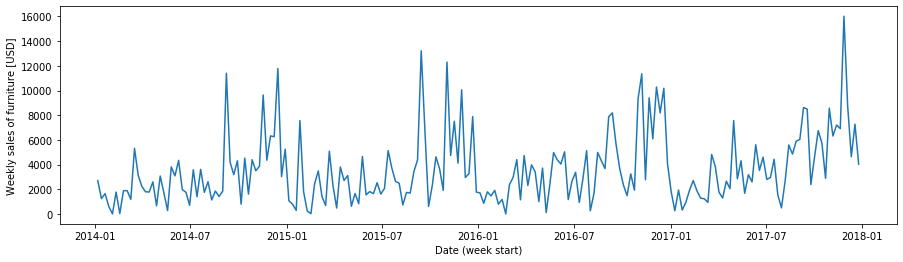

In [10]:
plt.figure(figsize=(15,4))
plt.xlabel('Date (week start)')
plt.ylabel('Weekly sales of furniture [USD]')
_ = plt.plot_date(sales_per_week['week'], sales_per_week['sales'], fmt='-')

[**REPORT**] Include the series binned by floating weeks in your report, plus a brief commentary.

## 1.3. Smooth the series by binning per month

Now we repeat the process for months instead of weeks. Now, however, we want to align the monthly sales to the **beginning of a calendar month**.

[**CODE**] Complete the function `list_of_month_starts`. It should return an array containing entries of the form *Year-Month-01*, that is the first of every month. It should start with the first of the month of the first observation, and end with the first of the month following the last observation.

* Given date D, to obtain the first of the month use `D1 = D.replace(day=1)`
* Given date D, to obtain the same date in the next month:
   * If *D.month < 12*, use `D2 = D.replace(month=D.month+1)`
   * If *D.month == 12*, use `D2 = D.replace(year=D.year+1, month=1)`

In [11]:
def list_of_month_starts(first, last):
    months = []
    
    # YOUR CODE HERE
    current_time = first
    months.append(current_time.replace(day=1))
    while current_time <= last:
        current_time = current_time.replace(day=1)
        if current_time.month < 12:
            current_time = current_time.replace(month=current_time.month+1)
        elif current_time.month == 12:
            current_time = current_time.replace(year=current_time.year+1, month=1)
        months.append(current_time)
    
    return(months)

first_day = np.min(sales_per_day['day'])
last_day = np.max(sales_per_day['day'])
months = list_of_month_starts(first_day, last_day)

print("There are %d month starts" % len(months))
print("First month starts %s, last month starts %s" % (months[0].strftime("%Y-%m-%d"), months[-1].strftime("%Y-%m-%d")))

There are 49 month starts
First month starts 2014-01-01, last month starts 2018-01-01


In [12]:
date_to_month_start = {}
month_num = 0

for index, row in sales_per_day.iterrows():
    day = row['day']
    while not (day >= months[month_num] and day < months[month_num+1]):
        month_num += 1
    date_to_month_start[day] = months[month_num]
    
print("Start of the month for date %s is %s" % (sales_per_day['day'][0], date_to_month_start[sales_per_day['day'][0]]))
print("Start of the month for date %s is %s" % (sales_per_day['day'][30], date_to_month_start[sales_per_day['day'][30]]))
print("Start of the month for date %s is %s" % (sales_per_day['day'][200], date_to_month_start[sales_per_day['day'][200]]))
print("Start of the month for date %s is %s" % (sales_per_day['day'][888], date_to_month_start[sales_per_day['day'][888]]))

Start of the month for date 2014-01-06 00:00:00 is 2014-01-01 00:00:00
Start of the month for date 2014-03-25 00:00:00 is 2014-03-01 00:00:00
Start of the month for date 2015-01-02 00:00:00 is 2015-01-01 00:00:00
Start of the month for date 2017-12-30 00:00:00 is 2017-12-01 00:00:00


[**CODE**] Complete the code to create the sales per month matrix. This is analogous to code above for weeks.

In [13]:
sales_per_month_dict = {}
for index, row in sales_per_day.iterrows():
    sales = row['sales']
    day = row['day']
    # YOUR CODE HERE
    # You have to create a new entry or add to an existing one
    # in the sales_per_month_dict dictionary.
    if date_to_month_start[day] in sales_per_month_dict:
        sales_per_month_dict[date_to_month_start[day]] += sales
    else:
        sales_per_month_dict[date_to_month_start[day]] = sales
        
sales_per_month_matrix = sorted([[date,sales] for date, sales in sales_per_month_dict.items()])
sales_per_month = pd.DataFrame(sales_per_month_matrix, columns=['month', 'sales'])
print(sales_per_month.head())
print("...")
print(sales_per_month.tail())

       month      sales
0 2014-01-01   6242.525
1 2014-02-01   1839.658
2 2014-03-01  14573.956
3 2014-04-01   7944.837
4 2014-05-01   6912.787
...
        month       sales
43 2017-08-01  15441.8740
44 2017-09-01  29028.2060
45 2017-10-01  21884.0682
46 2017-11-01  37056.7150
47 2017-12-01  31407.4668


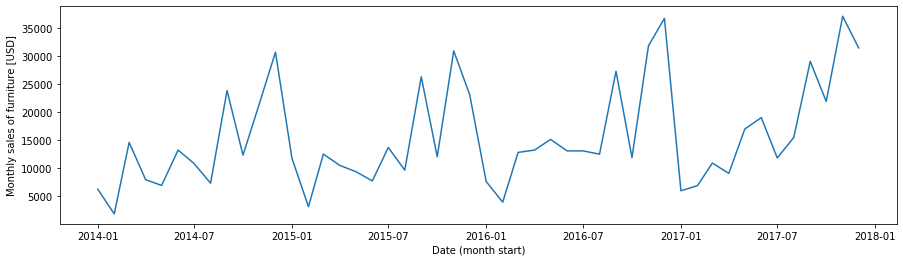

In [14]:
plt.figure(figsize=(15,4))
plt.xlabel('Date (month start)')
plt.ylabel('Monthly sales of furniture [USD]')
_ = plt.plot_date(sales_per_month['month'], sales_per_month['sales'], fmt='-')

[**REPORT**] Include the series binned by calendar months in your report, plus a brief commentary.

# 2. Perform forecasting

We will next perform a simple auto-regressive forecasting.

## 2.1. Compute auto-correlation plots

We will start by computing auto-correlation plots, which show to what extent a series is correlated with itself if we consider a certain `lag`, or time difference.

The function `lagged_series` returns the original series, and a second series computed by looking at *lag* periods in the past. It also takes care of "trimming" the edges of both series, so they will be of the same length.

[**CODE**] Complete the code of the function below to return `original` as the original series trimmed, and `lagged` as the lagged (shifted) series.

In [15]:
def lagged_series(series, lag):
    if lag == 0:
        original = lagged = series
    else:
        original = series[(lag):]
        lagged = series[:-(lag)]
    #for i in range(len(series)):
        #j = i - lag
        # YOUR CODE HERE
        # You have to append series[i] to original and series[j] to lagged
        # but only if j is in [0, len(series)-1]
        
    return original, lagged  

In [16]:
lagged_series([10,20,30,40,50,60], 2)

([30, 40, 50, 60], [10, 20, 30, 40])

The function `autocorrelation` simply computes Pearson's correlation between a series and the series lagged *lag* periods.

In [17]:
def autocorrelation(series, lag):
    x,y = lagged_series(series, lag)
            
    return stats.pearsonr(x,y)[0]  

Now we create an autocorrelation plot for the monthly sales.

[**CODE**] Complete the code below to compute autocorrelations in the series binned by month (`sales_per_month`) from *lag=0* to *lag=max_periods*. The autocorrelation with *lag=0* will always be *1.0*

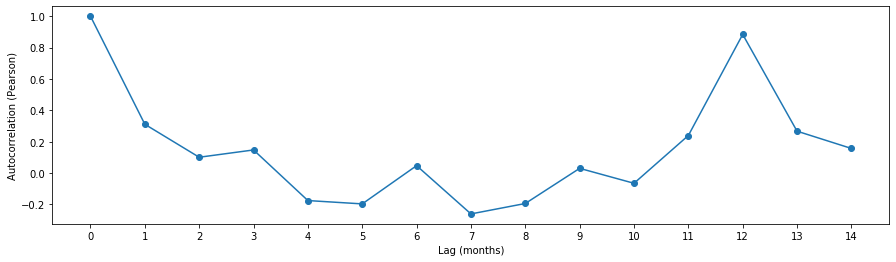

In [18]:
max_periods = 15

correlations = []
# YOUR CODE HERE
for i in range(max_periods):
    correlations.append(autocorrelation(sales_per_month['sales'].to_numpy(), i))
    
plt.figure(figsize=(15,4))
plt.xlabel("Lag (months)")
plt.ylabel("Autocorrelation (Pearson)")
plt.xticks(range(max_periods))
_ = plt.plot(range(max_periods), correlations, '-o')

[**REPORT**] Include the autocorrelation plot of the monthly series in your report, with a brief commentary.

[**CODE**] Complete the code below to compute autocorrelations in the series binned by weeks (`sales_per_week`) from *lag=0* to *lag=max_periods*. The autocorrelation with *lag=0* will always be *1.0*

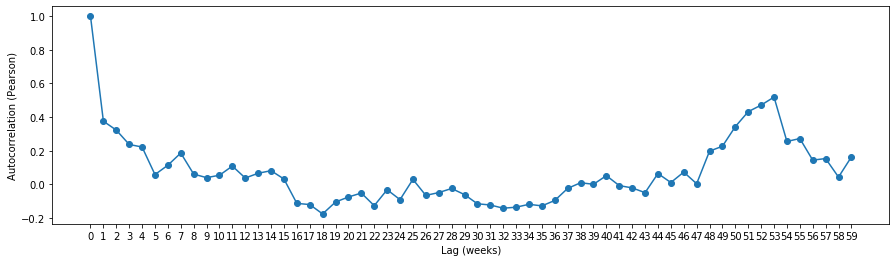

In [19]:
max_periods = 60

correlations = []
# YOUR CODE HERE
for i in range(max_periods):
    correlations.append(autocorrelation(sales_per_week['sales'].to_numpy(), i))
    
plt.figure(figsize=(15,4))
plt.xlabel("Lag (weeks)")
plt.ylabel("Autocorrelation (Pearson)")
plt.xticks(range(max_periods))
_ = plt.plot(range(max_periods), correlations, '-o')

[**REPORT**] Include the autocorrelation plot of the weekly series in your report, with a brief commentary.

## 2.2. Use linear regression to learn an auto-regressive model

We will now learn an auto-regressive model, which computes the current value from a series of values in the past, at different *lags*.

**Example:** In the explanation we will assume there are two lags (2, 3) only. This means that the value will be predicted on the basis of the value observed 2 and 3 periods ago. The equation is then *y[i] = y[i-2] x alpha + y[i-3] x beta*, with *alpha* and *beta* being two unknown coefficients that we must determine. Suppose the series is: [11, 19, 32, 38, 51, 58, 68, 81]. From this series, we create the following system of equations.

* 19 x alpha + 11 x beta = 38
* 32 x alpha + 19 x beta = 51
* ...
* 58 x alpha + 51 x beta = 81

Then, we will use SciKit's [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to obtain *alpha* and *beta*. To use this function, we need to prepare to matrices: *X*, which will contain the numbers in the left side of the equations, and *y* which will be a vector containing the numbers in the right side of the equations.

[**CODE**] Complete the function below to generate the matrix *X* and the vector *y*.

In [25]:
def prepare_matrices(series, lags):
    y = []
    X = []
    
    for lag in lags:
        assert(lag > 0)
        assert(lag < len(series))
    
    for i in range(np.max(lags), len(series)):
        row = []
        # YOUR CODE HERE
        for lag in lags:
            row.append(series[i-lag])
            
        X.append(row)
        y.append(series[i])
        
    return X, y

X, y = prepare_matrices([11, 19, 32, 38, 51, 58, 69, 81], [2, 3])
print("X=%s" % X)
print("y=%s" % y)

X=[[19, 11], [32, 19], [38, 32], [51, 38], [58, 51]]
y=[38, 51, 58, 69, 81]


Now we will perform the linear regression in the weekly series.

[**CODE**] Provide the second argument to prepare_matrices, based on the auto-correlation plot of the weekly series. Include up to 5 lags, and try different values until you find a low RMSE (we will be overfitting which is not recommended, but this is just an exercise to learn the technique).

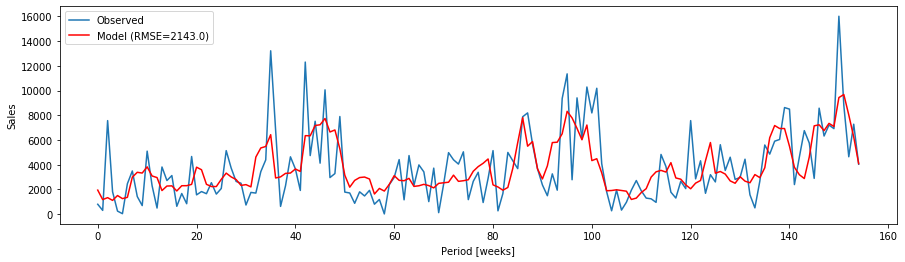

In [21]:
X, y = prepare_matrices(sales_per_week['sales'], [50,51,52,53])

linear_regressor = LinearRegression()
linear_regressor.fit(X,y)
y_pred = linear_regressor.predict(X)
rmse = math.sqrt(mean_squared_error(y, y_pred)) # Root mean squared error, in a scale of sales per week

plt.figure(figsize=(15,4))
plt.xlabel("Period [weeks]")
plt.ylabel("Sales")
plt.plot(y, label='Observed')
plt.plot(y_pred, color='red', label='Model (RMSE=%.1f)' % rmse)
plt.legend()
plt.show()

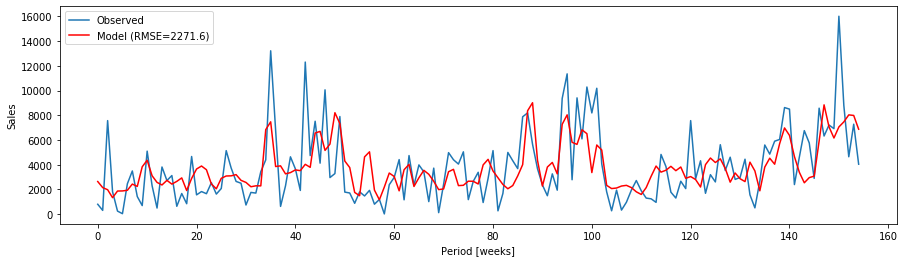

In [22]:
X, y = prepare_matrices(sales_per_week['sales'], [52,53])

linear_regressor = LinearRegression()
linear_regressor.fit(X,y)
y_pred = linear_regressor.predict(X)
rmse = math.sqrt(mean_squared_error(y, y_pred)) # Root mean squared error, in a scale of sales per week

plt.figure(figsize=(15,4))
plt.xlabel("Period [weeks]")
plt.ylabel("Sales")
plt.plot(y, label='Observed')
plt.plot(y_pred, color='red', label='Model (RMSE=%.1f)' % rmse)
plt.legend()
plt.show()

[**REPORT**] Include two plots with your model of the weekly series, one with up to 5 lags, and one with 2 lags only. Pick the best lags that minimize RMSE.

[**CODE**] Provide the second argument to prepare_matrices, based on the auto-correlation plot of the monthly series. Include up to 5 lags, and try different values until you find a low RMSE (again, we will be overfitting which is not recommended).

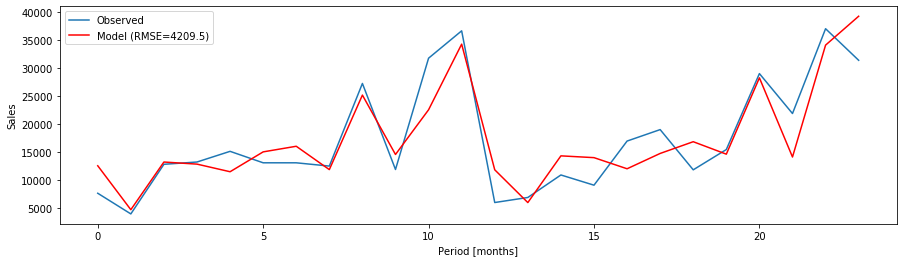

In [23]:
#Original: RMSE: 4206.3  Range: fins al 35
X, y = prepare_matrices( sales_per_month['sales'], [1,12,24])

linear_regressor = LinearRegression()
linear_regressor.fit(X,y)
y_pred = linear_regressor.predict(X)
rmse = math.sqrt(mean_squared_error(y, y_pred)) # Root mean squared error, in a scale of sales per month

plt.figure(figsize=(15,4))
plt.xlabel("Period [months]")
plt.ylabel("Sales")
plt.plot(y, label='Observed')
plt.plot(y_pred, color='red', label='Model (RMSE=%.1f)' % rmse)
plt.legend()
plt.show()

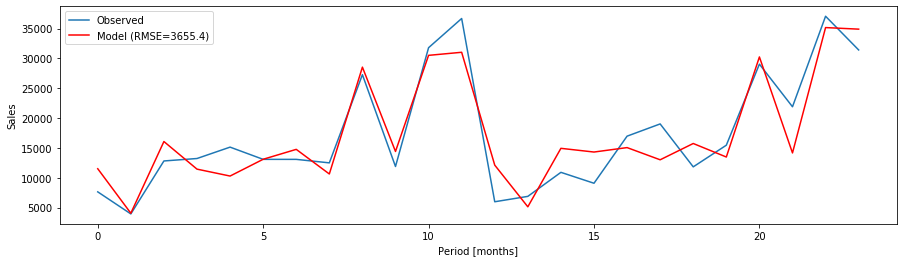

In [24]:
#Original: RMSE: 4206.3  Range: fins al 35
X, y = prepare_matrices( sales_per_month['sales'], [12,24])

linear_regressor = LinearRegression()
linear_regressor.fit(X,y)
y_pred = linear_regressor.predict(X)
rmse = math.sqrt(mean_squared_error(y, y_pred)) # Root mean squared error, in a scale of sales per month

plt.figure(figsize=(15,4))
plt.xlabel("Period [months]")
plt.ylabel("Sales")
plt.plot(y, label='Observed')
plt.plot(y_pred, color='red', label='Model (RMSE=%.1f)' % rmse)
plt.legend()
plt.show()

[**REPORT**] Include two plots with your model of the monthly series, one with up to 5 lags, and one with 2 lags only. Pick the best lags that minimize RMSE.

# 3. Deliver

Deliver:

* A zip file containing your notebook (.ipynb file) with all the [**CODE**] parts implemented.
* A PDF report of up to 4 pages including all parts of this notebook marked with "[**REPORT**]". Remember to include a brief commentary for each plot/figure.
The report should end with the following statement: **I hereby declare that, except for the code provided by the course instructors, all of our code, report, and figures were produced by myself.**